In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm



In [2]:
import glob
import math
import torch
import random
import inspect
import os.path as osp
import torch.nn as nn
from pathlib import Path
from itertools import chain
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv


In [4]:
import os.path as osp
import torch
from torch_geometric.data import Dataset, Data
import itertools
import numpy as np 
import pandas as pd
import glob
import multiprocessing
from pathlib import Path


In [7]:
import awkward

import numpy as np
import pandas as pd
import uproot
import awkward0

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [5]:
import h5py

#Data Samples
DATA_PATH = '/eos/cms/store/group/phys_b2g/CASE/h5_files/full_run2/BB_UL_MC_small_v2/'

TRAIN_NAME = 'BB_batch0.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
batch_size = 128
train_set_size = int((5*10e3//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

file_bg = h5py.File(filename_bg, 'r') 
#constituents = data['jetConstituentsList'][0:train_set_size+1,]
#features = data['eventFeatures'][0:train_set_size+1,]

In [6]:
print(list(file_bg.keys()))
print(np.array(file_bg['truth_label']).shape)
print(file_bg['jet1_extraInfo'].shape)

['event_info', 'jet1_PFCands', 'jet1_extraInfo', 'jet2_PFCands', 'jet2_extraInfo', 'jet_kinematics', 'truth_label']
(1037801, 1)
(1037801, 7)


In [7]:
import sys, os
from importlib import reload

#import utils.preprocessing as prepr
#reload(prepr)

In [8]:
import matplotlib.pyplot as plt
import numpy as np


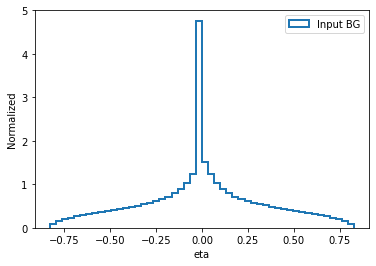

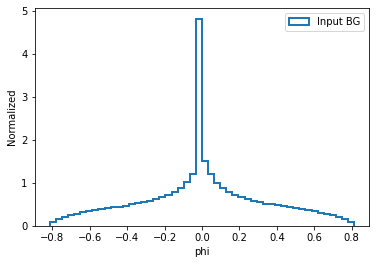

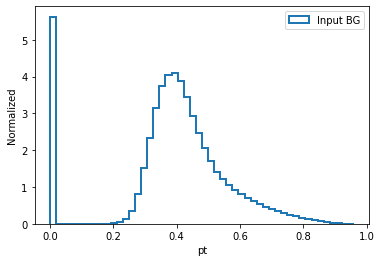

In [11]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    #plt.semilogy()
    plt.show()

In [49]:
deta_jj = 1.4
jPt = 400

def xyze_to_eppt(constituents):
    ''' converts an array [N x 100, 4] of particles
from px, py, pz, E to eta, phi, pt (mass omitted)
    '''
    PX, PY, PZ, E = range(4)
    pt = np.sqrt(np.float_power(constituents[:,PX], 2) + np.float_power(constituents[:,PY], 2), dtype='float32') # numpy.float16 dtype -> float power to avoid overflow
    eta = np.arcsinh(np.divide(constituents[:,PZ], pt, out=np.zeros_like(pt), where=pt!=0.), dtype='float32')
    phi = np.arctan2(constituents[:,PY], constituents[:,PX], dtype='float32')

    return np.stack([pt, eta, phi], axis=1)

side = True
to_train = True

datas = []
for i_e in range(1000):
    if to_train: 
        if file_bg['truth_label'][i_e]!=0 : #train only on QCD
            continue 
    if side :
        if not (file_bg["jet_kinematics"][i_e,1] > deta_jj):
            continue
    else : 
        if not (file_bg["jet_kinematics"][i_e,1] < deta_jj):
            continue
    for i_j in range(2): #each event has 2 jets
        pf_cands = np.array(file_bg["jet{}_PFCands".format(i_j+1)][i_e])
        pf_pt_eta_phi = xyze_to_eppt(pf_cands)
        n_particles = int(np.sum(pf_pt_eta_phi[:,0]!=0)) #if pt!=0
        particles = np.zeros((n_particles, 7)) #px,py,pz,E, pt, eta, phi = 7
        #particles = np.dstack((pf_cands[0:n_particles,:],np.array(pf_pt_eta_phi[0:n_particles,:])))
        particles = np.hstack((pf_cands[0:n_particles,:],np.array(pf_pt_eta_phi[0:n_particles,:])))
        pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles),range(n_particles)) if m!=n])
        edge_index = torch.tensor(pairs, dtype=torch.long)
        edge_index=edge_index.t().contiguous()
        # save particles as node attributes and target
        x = torch.tensor(particles, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        datas.append([data])
datas = sum(datas,[])

In [112]:
def xyze_to_ptep(constituents):
    ''' converts an array [N x 100, 4] of particles
from px, py, pz, E to eta, phi, pt (mass omitted)
    '''
    PX, PY, PZ, E = range(4)
    pt = np.sqrt(np.float_power(constituents[:,:,PX], 2) + np.float_power(constituents[:,:,PY], 2), dtype='float32') # numpy.float16 dtype -> float power to avoid overflow
    eta = np.arcsinh(np.divide(constituents[:,:,PZ], pt, out=np.zeros_like(pt), where=pt!=0.), dtype='float32')
    phi = np.arctan2(constituents[:,:,PY], constituents[:,:,PX], dtype='float32')

    return np.stack([pt, eta, phi], axis=2)

def get_present_constit(x,n):
    return x[0:n,:] 

def concat_features(feats_1,feats_2):
    return np.hstack((feats_1[:,:],feats_2[:,:]))

deta_jj = 1.4
jPt = 400

pt_mask_1 = (file_bg["jet_kinematics"][:,2:3][:,0] > jPt)
pt_mask_2 = (file_bg["jet_kinematics"][:,6:7][:,0] > jPt)
sig_mask = (file_bg["jet_kinematics"][:,1:2][:,0] < deta_jj) & pt_mask_1 & pt_mask_2
side_mask = (file_bg["jet_kinematics"][:,1:2][:,0] > deta_jj) & pt_mask_1 & pt_mask_2

side = True
full_mask = side_mask
if not side :
    full_mask = sig_mask

test_datas = []

print(np.array(file_bg["jet_kinematics"])[full_mask].shape)

for i_j in range(0): #each event has 2 jets
    pf_xyze = np.array(file_bg["jet{}_PFCands".format(i_j+1)])[full_mask][0:50]
    pf_ptep = xyze_to_ptep(pf_xyze)
    n_particles = np.sum(pf_xyze[:,:,3]!=0,axis=1) #E is 3rd 
    pf_xyze_out = list(map(get_present_constit,pf_xyze,n_particles))
    pf_ptep_out = list(map(get_present_constit,pf_ptep,n_particles))
    pf_tot_out = list(map(concat_features,pf_xyze_out,pf_ptep_out))

    for i in range(0,0): #np.array(file_bg["jet1_PFCands"])[full_mask].shape[0]):# 50 events
        pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles[i]),range(n_particles[i])) if m!=n])
        edge_index = torch.tensor(pairs, dtype=torch.long)
        edge_index=edge_index.t().contiguous()
        # save particles as node attributes and target
        x = torch.tensor(np.hstack((pf_xyze_out[i][:,:],pf_ptep_out[i][:,:])), dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        test_datas.append([data])



(360754, 14)


In [9]:
def xyze_to_ptep(constituents):
    ''' converts an array [N x 100, 4] of particles
from px, py, pz, E to eta, phi, pt (mass omitted)
    '''
    PX, PY, PZ, E = range(4)
    pt = np.sqrt(np.float_power(constituents[:,:,PX], 2) + np.float_power(constituents[:,:,PY], 2), dtype='float32') # numpy.float16 dtype -> float power to avoid overflow
    eta = np.arcsinh(np.divide(constituents[:,:,PZ], pt, out=np.zeros_like(pt), where=pt!=0.), dtype='float32')
    phi = np.arctan2(constituents[:,:,PY], constituents[:,:,PX], dtype='float32')

    return np.stack([pt, eta, phi], axis=2)

def get_present_constit(x,n):
    return x[0:n,:] 

def concat_features(feats_1,feats_2):
    return np.hstack((feats_1[:,:],feats_2[:,:]))

deta_jj = 1.4
jPt = 400

pt_mask_1 = (file_bg["jet_kinematics"][:,2:3][:,0] > jPt)
pt_mask_2 = (file_bg["jet_kinematics"][:,6:7][:,0] > jPt)
sig_mask = (file_bg["jet_kinematics"][:,1:2][:,0] < deta_jj) & pt_mask_1 & pt_mask_2
side_mask = (file_bg["jet_kinematics"][:,1:2][:,0] > deta_jj) & pt_mask_1 & pt_mask_2

side = True
full_mask = side_mask
if not side :
    full_mask = sig_mask


pf_xyze = np.array(file_bg["jet1_PFCands"])[full_mask]



_px = pf_xyze[:,:,0]
_py = pf_xyze[:,:,1]
_pz = pf_xyze[:,:,2]
_e = pf_xyze[:,:,3]


In [1]:
deta_jj = 1.4
jPt = 400

pt_mask_1 = (file_bg["jet_kinematics"][:,2:3][:,0] > jPt)
pt_mask_2 = (file_bg["jet_kinematics"][:,6:7][:,0] > jPt)
sig_mask = (file_bg["jet_kinematics"][:,1:2][:,0] < deta_jj) & pt_mask_1 & pt_mask_2
side_mask = (file_bg["jet_kinematics"][:,1:2][:,0] > deta_jj) & pt_mask_1 & pt_mask_2

side = True
full_mask = side_mask
if not side :
    full_mask = sig_mask


pf_xyze = np.array(file_bg["jet1_PFCands"])[full_mask]



_px = pf_xyze[:,:,0]
_py = pf_xyze[:,:,1]
_pz = pf_xyze[:,:,2]
_e = pf_xyze[:,:,3]


NameError: name '_e' is not defined

In [8]:
deta_jj = 1.4
jPt = 400

pt_mask_1 = (file_bg["jet_kinematics"][:,2:3][:,0] > jPt)
pt_mask_2 = (file_bg["jet_kinematics"][:,6:7][:,0] > jPt)
sig_mask = (file_bg["jet_kinematics"][:,1:2][:,0] < deta_jj) & pt_mask_1 & pt_mask_2
side_mask = (file_bg["jet_kinematics"][:,1:2][:,0] > deta_jj) & pt_mask_1 & pt_mask_2
truth = (file_bg["truth"][:,0]==0) 


side = True
full_mask = side_mask
if not side :
    full_mask = sig_mask
full_mask = full_mask&truth

pf_xyze = np.array(file_bg["jet1_PFCands"])[full_mask]

pf_xyze.shape

(360754, 100, 4)

In [16]:
truth = (file_bg["truth_label"][:,0]>0) 
full_mask_sig = sig_mask&truth

pf_xyze = np.array(file_bg["jet1_PFCands"])[full_mask_sig]
pf_xyze.shape
#one file with qcd only  356039 x 2 (jets ) = 700000 

(2854, 100, 4)

In [10]:
# We filter out the non-0 non-negative energy particles
pf_xyze = np.array(file_bg["jet1_PFCands"])
_px = pf_xyze[:,:,0]
_py = pf_xyze[:,:,1]
_pz = pf_xyze[:,:,2]
_e = pf_xyze[:,:,3]
jet_mask = 
mask = _e> 0

n_particles = np.sum(mask, axis=1) # Number of particles for each event where energy is greater than 0
    # _p[mask] filters out the >0 energy particles, and flattens them, so that they can be recollected for each event from counts array.
px = awkward0.JaggedArray.fromcounts(n_particles, _px[mask])
py = awkward0.JaggedArray.fromcounts(n_particles, _py[mask])
pz = awkward0.JaggedArray.fromcounts(n_particles, _pz[mask])
energy = awkward0.JaggedArray.fromcounts(n_particles, _e[mask])

In [24]:
#import scipy
#from scipy.sparse import csr_matrix
adj = [csr_matrix(np.ones((n_part,n_part)) - np.eye(n_part)) for n_part in n_particles]


NameError: name 'from_scipy_sparse_matrix' is not defined

In [ ]:
from torch_geometric.utils import from_scipy_sparse_matrix
edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj] 

In [121]:
print(np.vstack((np.array(file_bg["jet_kinematics"])[full_mask],np.array(file_bg["jet_kinematics"])[full_mask])).shape)


(721508, 14)


In [36]:
def access(x,n):
    return x[0:n,:]  

    
result_xyze = list(map(access,pf_cands_1,n_particles_1))
result_ptetaphi = list(map(access,pf_pt_eta_phi_1,n_particles_1))

test_datas = []
for i in range(0,50):# 50 events
    pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles_1[i]),range(n_particles_1[i])) if m!=n])
    edge_index = torch.tensor(pairs, dtype=torch.long)
    edge_index=edge_index.t().contiguous()
    # save particles as node attributes and target
    #x = torch.tensor(np.hstack((result_xyze[i][i,:,:],result_ptetaphi[i][i,:,:])), dtype=torch.float)
    x = torch.tensor(np.hstack((result_xyze[i][:,:],result_ptetaphi[i][:,:])), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    test_datas.append([data])

In [43]:
test_datas


[[Data(edge_index=[2, 2070], x=[46, 7])],
 [Data(edge_index=[2, 1892], x=[44, 7])],
 [Data(edge_index=[2, 2652], x=[52, 7])],
 [Data(edge_index=[2, 3422], x=[59, 7])],
 [Data(edge_index=[2, 2550], x=[51, 7])],
 [Data(edge_index=[2, 600], x=[25, 7])],
 [Data(edge_index=[2, 7656], x=[88, 7])],
 [Data(edge_index=[2, 9312], x=[97, 7])],
 [Data(edge_index=[2, 240], x=[16, 7])],
 [Data(edge_index=[2, 2862], x=[54, 7])],
 [Data(edge_index=[2, 552], x=[24, 7])],
 [Data(edge_index=[2, 1560], x=[40, 7])],
 [Data(edge_index=[2, 3422], x=[59, 7])],
 [Data(edge_index=[2, 5112], x=[72, 7])],
 [Data(edge_index=[2, 2256], x=[48, 7])],
 [Data(edge_index=[2, 2862], x=[54, 7])],
 [Data(edge_index=[2, 1892], x=[44, 7])],
 [Data(edge_index=[2, 552], x=[24, 7])],
 [Data(edge_index=[2, 992], x=[32, 7])],
 [Data(edge_index=[2, 3906], x=[63, 7])],
 [Data(edge_index=[2, 2070], x=[46, 7])],
 [Data(edge_index=[2, 1980], x=[45, 7])],
 [Data(edge_index=[2, 5402], x=[74, 7])],
 [Data(edge_index=[2, 552], x=[24, 7])]

In [41]:
#n_particles_1.shape
#print(np.array(pf_cands_1[:,:n_particles_1[:],:]).shape)
     # ,np.array(pf_pt_eta_phi_1[0:n_particles_1,:].shape))

#np.array([pf_cands_1[i,0:n_particles_1[i],:] for i in range(50)], dtype="object").shape


#out = np.dstack((np.array([pf_cands_1[i,0:n_particles_1[i],:] for i in range(50)]),np.array([pf_pt_eta_phi_1[i,0:n_particles_1[i],:]])) for i in range(50))


In [41]:
out.shape

(1, 2, 50)

In [51]:
for key, item in datas[2]:
    print("{} found in data".format(key))

edge_index found in data
x found in data


In [57]:
pf_cands_1 = np.array(file_bg["jet1_PFCands"])[full_mask][0:1000]


In [63]:
n_particles = np.sum(pf_cands_1[:,:,3]!=0,axis=1) #if pt!=0


In [68]:
np.vstack((pf_cands_1,pf_cands_1)).shape

(2000, 100, 4)

In [46]:
np.array(file_bg["jet1_PFCands"])[full_mask].shape

(360754, 100, 4)

In [106]:
"""
    Model definitions.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv


# GNN AE using EdgeConv (mean aggregation graph operation). Basic GAE model.
class EdgeNet(nn.Module):
    def __init__(self, input_dim=4, big_dim=32, hidden_dim=2, aggr='mean'):
        super(EdgeNet, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(input_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, hidden_dim),
                               nn.ReLU(),
        )
        
        decoder_nn = nn.Sequential(nn.Linear(2*(hidden_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)
        self.decoder = EdgeConv(nn=decoder_nn,aggr=aggr)

    def forward(self, data):
        x = self.batchnorm(data.x)
        x = self.encoder(x,data.edge_index)
        x = self.decoder(x,data.edge_index)
        return x

In [107]:
from torch_geometric.data import Data

#data_list = [datas]
loader = DataLoader(datas, batch_size=128)

NameError: name 'datas' is not defined

In [108]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = torch.cuda.device_count()>1

In [86]:
#random.Random(0).shuffle(loader)


TypeError: 'DataLoader' object does not support indexing

In [93]:
class Standardizer:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        """
        :param data: torch tensor
        """
        self.mean = torch.mean(data, dim=0)
        self.std = torch.std(data, dim=0)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data, log_pt=False):
        """
        :param data: torch tensor
        :param log_pt: undo log transformation on pt
        """
        inverse = (data * self.std) + self.mean
        if log_pt:
            inverse[:,0] = (10 ** inverse[:,0]) - 1
        return inverse

def standardize(train_dataset,log_pt=False):
    """
    standardize dataset and return scaler for inversion
    :param train_dataset: list of Data objects
    :param valid_dataset: list of Data objects
    :param test_dataset: list of Data objects
    :param log_pt: log pt before standardization
    :return scaler: sklearn StandardScaler
    """
    train_x = torch.cat([d.x for d in train_dataset])
    if log_pt:
        train_x[:,0] = torch.log(train_x[:,0] + 1)

    scaler = Standardizer()
    scaler.fit(train_x)
    for d in train_dataset:
        d.x[:,:] = scaler.transform(d.x)
    return scaler

In [94]:
scaler = standardize(datas)


In [109]:
# model
input_dim = 7
big_dim = 32
hidden_dim = 2
model = EdgeNet(input_dim=input_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

In [110]:
model.to(device)


EdgeNet(
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=7, bias=True)
  ))
)

In [122]:
loss_ftn_obj = LossFunction('mse', device=device)


# Training loop
n_epochs = 10
stale_epochs = 0
loss = 999999
train_losses = []
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, dataloaders['train'], len(datas), 128, loss_ftn_obj)
    train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))







  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.3410999:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.3410999:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2598591:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2598591:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2598591:  13%|█▎        | 2/15.625 [00:00<00:00, 19.00it/s]




train loss = 0.2807960:  13%|█▎        | 2/15.625 [00:00<00:00, 19.00it/s]




train loss = 0.2807960:  13%|█▎        | 2/15.625 [00:00<00:00, 19.00it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.2406538:  13%|█▎        | 2/15.625 [00:00<00:00, 19.00it/s]




train loss = 0.2406538:  13%|█▎        | 2/15.625 [00:00<00:00, 19.00it/s]




train loss = 0.2406538:  26%|██▌       | 4/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.2811480:  26%|██▌       | 4/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.2811480:  26%|██▌       | 4/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.3360034:  26%|██▌       | 4/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.3360034:  26%|██▌       | 4/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.3360034:  38%|███▊      | 6/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.4277634:  38%|███▊      | 6/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.4277634:  38%|███▊      | 6/15.625 [00:00<00:00, 17.42it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.3264257:  38%|███▊      | 6/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.3264257:  38%|███▊      | 6/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.3264257:  51%|█████     | 8/15.625 [00:00<00:00, 17.28it/s]




train loss = 0.2628804:  51%|█████     | 8/15.625 [00:00<00:00, 17.28it/s]




train loss = 0.2628804:  51%|█████     | 8/15.625 [00:00<00:00, 17.28it/s]




train loss = 0.2805894:  51%|█████     | 8/15.625 [00:00<00:00, 17.28it/s]




train loss = 0.2805894:  51%|█████     | 8/15.625 [00:00<00:00, 17.28it/s]




train loss = 0.2805894:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.39it/s]




train loss = 0.3404593:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.39it/s]




train loss = 0.3404593:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.39it/s]




train loss = 0.2375471:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.39it/s]




train loss = 0.2375471:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.39it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.2375471:  77%|███████▋  | 12/15.625 [00:00<00:00, 18.00it/s]




train loss = 0.2859165:  77%|███████▋  | 12/15.625 [00:00<00:00, 18.00it/s]




train loss = 0.2859165:  77%|███████▋  | 12/15.625 [00:00<00:00, 18.00it/s]




train loss = 0.2177916:  77%|███████▋  | 12/15.625 [00:00<00:00, 18.00it/s]




train loss = 0.2177916:  77%|███████▋  | 12/15.625 [00:00<00:00, 18.00it/s]




train loss = 0.2177916:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.99it/s]




train loss = 0.2838838:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.99it/s]




train loss = 0.2838838:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.99it/s]




train loss = 0.3291848:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.99it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.3291848:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.99it/s]




train loss = 0.3291848: : 16it [00:00, 17.64it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2695261:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2695261:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2037083:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2037083:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.2037083:  13%|█▎        | 2/15.625 [00:00<00:00, 15.38it/s]




train loss = 0.2042797:  13%|█▎        | 2/15.625 [00:00<00:00, 15.38it/s]




train loss = 0.2042797:  13%|█▎        | 2/15.625 [00:00<00:00, 15.38it/s]

Epoch: 00, Training Loss:   0.2958
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1821070:  13%|█▎        | 2/15.625 [00:00<00:00, 15.38it/s]




train loss = 0.1821070:  13%|█▎        | 2/15.625 [00:00<00:00, 15.38it/s]




train loss = 0.1821070:  26%|██▌       | 4/15.625 [00:00<00:00, 16.49it/s]




train loss = 0.2137326:  26%|██▌       | 4/15.625 [00:00<00:00, 16.49it/s]




train loss = 0.2137326:  26%|██▌       | 4/15.625 [00:00<00:00, 16.49it/s]




train loss = 0.2594631:  26%|██▌       | 4/15.625 [00:00<00:00, 16.49it/s]




train loss = 0.2594631:  26%|██▌       | 4/15.625 [00:00<00:00, 16.49it/s]




train loss = 0.2594631:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.3209630:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.3209630:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]






moved data to device
moved data to device
moved data to device
moved data to device


train loss = 0.2521749:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.2521749:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.2123970:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.2123970:  38%|███▊      | 6/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.2123970:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.06it/s]




train loss = 0.2165953:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.06it/s]




train loss = 0.2165953:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.06it/s]




train loss = 0.2405385:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.06it/s]




train loss = 0.2405385:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.06it/s]




train loss = 0.2405385:  70%|███████   | 11/15.625 [00:00<00:00, 17.62it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1813847:  70%|███████   | 11/15.625 [00:00<00:00, 17.62it/s]




train loss = 0.1813847:  70%|███████   | 11/15.625 [00:00<00:00, 17.62it/s]




train loss = 0.2021545:  70%|███████   | 11/15.625 [00:00<00:00, 17.62it/s]




train loss = 0.2021545:  70%|███████   | 11/15.625 [00:00<00:00, 17.62it/s]




train loss = 0.2021545:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.76it/s]




train loss = 0.1706333:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.76it/s]




train loss = 0.1706333:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.76it/s]




train loss = 0.2075665:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.76it/s]




train loss = 0.2075665:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.76it/s]




train loss = 0.2075665:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.54it/s]




train loss = 0.2311883:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.54it/s]




train loss = 0.2311883:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.54it/s]




train loss = 0.2311883: : 16it [00:

moved data to device
moved data to device
moved data to device
moved data to device







  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1853160:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1853160:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1616198:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1616198:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1616198:  13%|█▎        | 2/15.625 [00:00<00:00, 18.68it/s]




train loss = 0.1632020:  13%|█▎        | 2/15.625 [00:00<00:00, 18.68it/s]




train loss = 0.1632020:  13%|█▎        | 2/15.625 [00:00<00:00, 18.68it/s]

Epoch: 01, Training Loss:   0.2230
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1474452:  13%|█▎        | 2/15.625 [00:00<00:00, 18.68it/s]




train loss = 0.1474452:  13%|█▎        | 2/15.625 [00:00<00:00, 18.68it/s]




train loss = 0.1474452:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.1587214:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.1587214:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.1984477:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.1984477:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.2450624:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.2450624:  26%|██▌       | 4/15.625 [00:00<00:00, 17.60it/s]




train loss = 0.2450624:  45%|████▍     | 7/15.625 [00:00<00:00, 17.76it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.2107556:  45%|████▍     | 7/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.2107556:  45%|████▍     | 7/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1632623:  45%|████▍     | 7/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1632623:  45%|████▍     | 7/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1632623:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1743307:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1743307:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1610731:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1610731:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1610731:  70%|███████   | 11/15.625 [00:00<00:00, 16.20it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1504237:  70%|███████   | 11/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.1504237:  70%|███████   | 11/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.1668733:  70%|███████   | 11/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.1668733:  70%|███████   | 11/15.625 [00:00<00:00, 16.20it/s]




train loss = 0.1668733:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.51it/s]




train loss = 0.1261615:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.51it/s]




train loss = 0.1261615:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.51it/s]




train loss = 0.1690386:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.51it/s]




train loss = 0.1690386:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.51it/s]




train loss = 0.1690386:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.16it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1933493:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.16it/s]




train loss = 0.1933493:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.16it/s]




train loss = 0.1933493: : 16it [00:00, 17.09it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1340199:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1340199:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1223904:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1223904:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1223904:  13%|█▎        | 2/15.625 [00:00<00:00, 15.26it/s]




train loss = 0.1316556:  13%|█▎        | 2/15.625 [00:00<00:00, 15.26it/s]




train loss = 0.1316556:  13%|█▎        | 2/15.625 [00:00<00:00, 15.26it/s]

Epoch: 02, Training Loss:   0.1734
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1272386:  13%|█▎        | 2/15.625 [00:00<00:00, 15.26it/s]




train loss = 0.1272386:  13%|█▎        | 2/15.625 [00:00<00:00, 15.26it/s]




train loss = 0.1272386:  26%|██▌       | 4/15.625 [00:00<00:00, 16.07it/s]




train loss = 0.1210851:  26%|██▌       | 4/15.625 [00:00<00:00, 16.07it/s]




train loss = 0.1210851:  26%|██▌       | 4/15.625 [00:00<00:00, 16.07it/s]




train loss = 0.1608743:  26%|██▌       | 4/15.625 [00:00<00:00, 16.07it/s]




train loss = 0.1608743:  26%|██▌       | 4/15.625 [00:00<00:00, 16.07it/s]




train loss = 0.1608743:  38%|███▊      | 6/15.625 [00:00<00:00, 15.92it/s]




train loss = 0.2160526:  38%|███▊      | 6/15.625 [00:00<00:00, 15.92it/s]




train loss = 0.2160526:  38%|███▊      | 6/15.625 [00:00<00:00, 15.92it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1652062:  38%|███▊      | 6/15.625 [00:00<00:00, 15.92it/s]




train loss = 0.1652062:  38%|███▊      | 6/15.625 [00:00<00:00, 15.92it/s]




train loss = 0.1652062:  51%|█████     | 8/15.625 [00:00<00:00, 16.36it/s]




train loss = 0.1302115:  51%|█████     | 8/15.625 [00:00<00:00, 16.36it/s]




train loss = 0.1302115:  51%|█████     | 8/15.625 [00:00<00:00, 16.36it/s]




train loss = 0.1463040:  51%|█████     | 8/15.625 [00:00<00:00, 16.36it/s]




train loss = 0.1463040:  51%|█████     | 8/15.625 [00:00<00:00, 16.36it/s]




train loss = 0.1463040:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.21it/s]




train loss = 0.1435895:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.21it/s]




train loss = 0.1435895:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.21it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1333022:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.21it/s]




train loss = 0.1333022:  64%|██████▍   | 10/15.625 [00:00<00:00, 17.21it/s]




train loss = 0.1333022:  77%|███████▋  | 12/15.625 [00:00<00:00, 16.23it/s]




train loss = 0.1444660:  77%|███████▋  | 12/15.625 [00:00<00:00, 16.23it/s]




train loss = 0.1444660:  77%|███████▋  | 12/15.625 [00:00<00:00, 16.23it/s]




train loss = 0.1178260:  77%|███████▋  | 12/15.625 [00:00<00:00, 16.23it/s]




train loss = 0.1178260:  77%|███████▋  | 12/15.625 [00:00<00:00, 16.23it/s]




train loss = 0.1178260:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.92it/s]




train loss = 0.1407926:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.92it/s]




train loss = 0.1407926:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.92it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1793700:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.92it/s]




train loss = 0.1793700:  90%|████████▉ | 14/15.625 [00:00<00:00, 16.92it/s]




train loss = 0.1793700: : 16it [00:00, 17.01it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1212300:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1212300:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0955278:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0955278:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0955278:  13%|█▎        | 2/15.625 [00:00<00:00, 18.91it/s]




train loss = 0.1228788:  13%|█▎        | 2/15.625 [00:00<00:00, 18.91it/s]




train loss = 0.1228788:  13%|█▎        | 2/15.625 [00:00<00:00, 18.91it/s]

Epoch: 03, Training Loss:   0.1446
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1056300:  13%|█▎        | 2/15.625 [00:00<00:00, 18.91it/s]




train loss = 0.1056300:  13%|█▎        | 2/15.625 [00:00<00:00, 18.91it/s]




train loss = 0.1056300:  26%|██▌       | 4/15.625 [00:00<00:00, 18.36it/s]




train loss = 0.0964911:  26%|██▌       | 4/15.625 [00:00<00:00, 18.36it/s]




train loss = 0.0964911:  26%|██▌       | 4/15.625 [00:00<00:00, 18.36it/s]




train loss = 0.1447606:  26%|██▌       | 4/15.625 [00:00<00:00, 18.36it/s]




train loss = 0.1447606:  26%|██▌       | 4/15.625 [00:00<00:00, 18.36it/s]




train loss = 0.1447606:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1881129:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1881129:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1240064:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1240064:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1130816:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1130816:  38%|███▊      | 6/15.625 [00:00<00:00, 17.57it/s]




train loss = 0.1130816:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1102135:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1102135:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1233723:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1233723:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.76it/s]




train loss = 0.1233723:  70%|███████   | 11/15.625 [00:00<00:00, 17.45it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1178204:  70%|███████   | 11/15.625 [00:00<00:00, 17.45it/s]




train loss = 0.1178204:  70%|███████   | 11/15.625 [00:00<00:00, 17.45it/s]




train loss = 0.1130461:  70%|███████   | 11/15.625 [00:00<00:00, 17.45it/s]




train loss = 0.1130461:  70%|███████   | 11/15.625 [00:00<00:00, 17.45it/s]




train loss = 0.1130461:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.16it/s]




train loss = 0.1044119:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.16it/s]




train loss = 0.1044119:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.16it/s]




train loss = 0.1308281:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.16it/s]




train loss = 0.1308281:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.16it/s]




train loss = 0.1308281:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1446541:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.1446541:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.83it/s]






moved data to device
moved data to device
moved data to device
moved data to device


train loss = 0.1446541: : 16it [00:00, 17.64it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1087712:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.1087712:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0829764:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0829764:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0829764:  13%|█▎        | 2/15.625 [00:00<00:00, 16.33it/s]




train loss = 0.1014809:  13%|█▎        | 2/15.625 [00:00<00:00, 16.33it/s]




train loss = 0.1014809:  13%|█▎        | 2/15.625 [00:00<00:00, 16.33it/s]

Epoch: 04, Training Loss:   0.1223
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0964468:  13%|█▎        | 2/15.625 [00:00<00:00, 16.33it/s]




train loss = 0.0964468:  13%|█▎        | 2/15.625 [00:00<00:00, 16.33it/s]




train loss = 0.0964468:  26%|██▌       | 4/15.625 [00:00<00:00, 16.98it/s]




train loss = 0.0874173:  26%|██▌       | 4/15.625 [00:00<00:00, 16.98it/s]




train loss = 0.0874173:  26%|██▌       | 4/15.625 [00:00<00:00, 16.98it/s]




train loss = 0.1215638:  26%|██▌       | 4/15.625 [00:00<00:00, 16.98it/s]




train loss = 0.1215638:  26%|██▌       | 4/15.625 [00:00<00:00, 16.98it/s]




train loss = 0.1215638:  38%|███▊      | 6/15.625 [00:00<00:00, 17.37it/s]




train loss = 0.1716386:  38%|███▊      | 6/15.625 [00:00<00:00, 17.37it/s]




train loss = 0.1716386:  38%|███▊      | 6/15.625 [00:00<00:00, 17.37it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1065327:  38%|███▊      | 6/15.625 [00:00<00:00, 17.37it/s]




train loss = 0.1065327:  38%|███▊      | 6/15.625 [00:00<00:00, 17.37it/s]




train loss = 0.1065327:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.0952871:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.0952871:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.0982533:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.0982533:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.1027523:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.1027523:  51%|█████     | 8/15.625 [00:00<00:00, 16.97it/s]




train loss = 0.1027523:  70%|███████   | 11/15.625 [00:00<00:00, 17.36it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1026345:  70%|███████   | 11/15.625 [00:00<00:00, 17.36it/s]




train loss = 0.1026345:  70%|███████   | 11/15.625 [00:00<00:00, 17.36it/s]




train loss = 0.0968882:  70%|███████   | 11/15.625 [00:00<00:00, 17.36it/s]




train loss = 0.0968882:  70%|███████   | 11/15.625 [00:00<00:00, 17.36it/s]




train loss = 0.0968882:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.32it/s]




train loss = 0.0863870:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.32it/s]




train loss = 0.0863870:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.32it/s]




train loss = 0.1182662:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.32it/s]




train loss = 0.1182662:  83%|████████▎ | 13/15.625 [00:00<00:00, 17.32it/s]




train loss = 0.1182662:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.13it/s]




train loss = 0.1295752:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.13it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1295752:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.13it/s]




train loss = 0.1295752: : 16it [00:00, 17.58it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0923108:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0923108:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0740217:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0740217:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0740217:  13%|█▎        | 2/15.625 [00:00<00:00, 19.68it/s]




train loss = 0.0884333:  13%|█▎        | 2/15.625 [00:00<00:00, 19.68it/s]




train loss = 0.0884333:  13%|█▎        | 2/15.625 [00:00<00:00, 19.68it/s]

Epoch: 05, Training Loss:   0.1067
moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0880903:  13%|█▎        | 2/15.625 [00:00<00:00, 19.68it/s]




train loss = 0.0880903:  13%|█▎        | 2/15.625 [00:00<00:00, 19.68it/s]




train loss = 0.0880903:  26%|██▌       | 4/15.625 [00:00<00:00, 18.40it/s]




train loss = 0.0784099:  26%|██▌       | 4/15.625 [00:00<00:00, 18.40it/s]




train loss = 0.0784099:  26%|██▌       | 4/15.625 [00:00<00:00, 18.40it/s]




train loss = 0.1111042:  26%|██▌       | 4/15.625 [00:00<00:00, 18.40it/s]




train loss = 0.1111042:  26%|██▌       | 4/15.625 [00:00<00:00, 18.40it/s]




train loss = 0.1111042:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.1549665:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.1549665:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.0954567:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0954567:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.0873585:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.0873585:  38%|███▊      | 6/15.625 [00:00<00:00, 17.29it/s]




train loss = 0.0873585:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.0948433:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.0948433:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.0957495:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.0957495:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.42it/s]




train loss = 0.0957495:  70%|███████   | 11/15.625 [00:00<00:00, 17.33it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0921142:  70%|███████   | 11/15.625 [00:00<00:00, 17.33it/s]




train loss = 0.0921142:  70%|███████   | 11/15.625 [00:00<00:00, 17.33it/s]




train loss = 0.0911629:  70%|███████   | 11/15.625 [00:00<00:00, 17.33it/s]




train loss = 0.0911629:  70%|███████   | 11/15.625 [00:00<00:00, 17.33it/s]




train loss = 0.0911629:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.18it/s]




train loss = 0.0820918:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.18it/s]




train loss = 0.0820918:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.18it/s]




train loss = 0.1085213:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.18it/s]




train loss = 0.1085213:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.18it/s]




train loss = 0.1085213:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.29it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1276268:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.29it/s]




train loss = 0.1276268:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.29it/s]




train loss = 0.1276268: : 16it [00:00, 16.61it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0837834:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0837834:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0680135:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0680135:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0680135:  13%|█▎        | 2/15.625 [00:00<00:00, 14.63it/s]

Epoch: 06, Training Loss:   0.0976
moved data to device
moved data to device
moved data to device







train loss = 0.0832683:  13%|█▎        | 2/15.625 [00:00<00:00, 14.63it/s]




train loss = 0.0832683:  13%|█▎        | 2/15.625 [00:00<00:00, 14.63it/s]




train loss = 0.0812449:  13%|█▎        | 2/15.625 [00:00<00:00, 14.63it/s]




train loss = 0.0812449:  13%|█▎        | 2/15.625 [00:00<00:00, 14.63it/s]




train loss = 0.0812449:  26%|██▌       | 4/15.625 [00:00<00:00, 15.33it/s]




train loss = 0.0704383:  26%|██▌       | 4/15.625 [00:00<00:00, 15.33it/s]




train loss = 0.0704383:  26%|██▌       | 4/15.625 [00:00<00:00, 15.33it/s]




train loss = 0.1075237:  26%|██▌       | 4/15.625 [00:00<00:00, 15.33it/s]




train loss = 0.1075237:  26%|██▌       | 4/15.625 [00:00<00:00, 15.33it/s]




train loss = 0.1075237:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1466660:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.1466660:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.0924857:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.0924857:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.0808107:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.0808107:  38%|███▊      | 6/15.625 [00:00<00:00, 14.93it/s]




train loss = 0.0808107:  58%|█████▊    | 9/15.625 [00:00<00:00, 15.98it/s]




train loss = 0.0946284:  58%|█████▊    | 9/15.625 [00:00<00:00, 15.98it/s]




train loss = 0.0946284:  58%|█████▊    | 9/15.625 [00:00<00:00, 15.98it/s]




train loss = 0.0900202:  58%|█████▊    | 9/15.625 [00:00<00:00, 15.98it/s]




train loss = 0.0900202:  58%|█████▊    | 9/15.625 [00:00<00:00, 15.98it/s]




train loss = 0.0900202:  70%|███████   | 11/15.625 [00:00<00:00, 16.65it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0846684:  70%|███████   | 11/15.625 [00:00<00:00, 16.65it/s]




train loss = 0.0846684:  70%|███████   | 11/15.625 [00:00<00:00, 16.65it/s]




train loss = 0.0878682:  70%|███████   | 11/15.625 [00:00<00:00, 16.65it/s]




train loss = 0.0878682:  70%|███████   | 11/15.625 [00:00<00:00, 16.65it/s]




train loss = 0.0878682:  83%|████████▎ | 13/15.625 [00:00<00:00, 15.95it/s]




train loss = 0.0774527:  83%|████████▎ | 13/15.625 [00:00<00:00, 15.95it/s]




train loss = 0.0774527:  83%|████████▎ | 13/15.625 [00:00<00:00, 15.95it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1000891:  83%|████████▎ | 13/15.625 [00:00<00:00, 15.95it/s]




train loss = 0.1000891:  83%|████████▎ | 13/15.625 [00:00<00:00, 15.95it/s]




train loss = 0.1000891:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.60it/s]




train loss = 0.1243666:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.60it/s]




train loss = 0.1243666:  96%|█████████▌| 15/15.625 [00:00<00:00, 16.60it/s]




train loss = 0.1243666: : 16it [00:00, 16.77it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0792162:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0792162:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0637727:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0637727:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0789559:   0%|          | 0/15.625 [00:00<?, ?it/s]






moved data to device
Epoch: 07, Training Loss:   0.0921
moved data to device
moved data to device
moved data to device


train loss = 0.0789559:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0789559:  19%|█▉        | 3/15.625 [00:00<00:00, 18.85it/s]




train loss = 0.0765090:  19%|█▉        | 3/15.625 [00:00<00:00, 18.85it/s]




train loss = 0.0765090:  19%|█▉        | 3/15.625 [00:00<00:00, 18.85it/s]




train loss = 0.0636298:  19%|█▉        | 3/15.625 [00:00<00:00, 18.85it/s]




train loss = 0.0636298:  19%|█▉        | 3/15.625 [00:00<00:00, 18.85it/s]




train loss = 0.0636298:  32%|███▏      | 5/15.625 [00:00<00:00, 17.81it/s]




train loss = 0.1057541:  32%|███▏      | 5/15.625 [00:00<00:00, 17.81it/s]




train loss = 0.1057541:  32%|███▏      | 5/15.625 [00:00<00:00, 17.81it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1420970:  32%|███▏      | 5/15.625 [00:00<00:00, 17.81it/s]




train loss = 0.1420970:  32%|███▏      | 5/15.625 [00:00<00:00, 17.81it/s]




train loss = 0.1420970:  45%|████▍     | 7/15.625 [00:00<00:00, 18.02it/s]




train loss = 0.0839199:  45%|████▍     | 7/15.625 [00:00<00:00, 18.02it/s]




train loss = 0.0839199:  45%|████▍     | 7/15.625 [00:00<00:00, 18.02it/s]




train loss = 0.0768604:  45%|████▍     | 7/15.625 [00:00<00:00, 18.02it/s]




train loss = 0.0768604:  45%|████▍     | 7/15.625 [00:00<00:00, 18.02it/s]




train loss = 0.0768604:  58%|█████▊    | 9/15.625 [00:00<00:00, 18.28it/s]




train loss = 0.0864626:  58%|█████▊    | 9/15.625 [00:00<00:00, 18.28it/s]




train loss = 0.0864626:  58%|█████▊    | 9/15.625 [00:00<00:00, 18.28it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0818676:  58%|█████▊    | 9/15.625 [00:00<00:00, 18.28it/s]




train loss = 0.0818676:  58%|█████▊    | 9/15.625 [00:00<00:00, 18.28it/s]




train loss = 0.0818676:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0804271:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0804271:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0734585:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0734585:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0694174:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0694174:  70%|███████   | 11/15.625 [00:00<00:00, 17.14it/s]




train loss = 0.0694174:  90%|████████▉ | 14/15.625 [00:00<00:00, 17.52it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0951064:  90%|████████▉ | 14/15.625 [00:00<00:00, 17.52it/s]




train loss = 0.0951064:  90%|████████▉ | 14/15.625 [00:00<00:00, 17.52it/s]




train loss = 0.1095771:  90%|████████▉ | 14/15.625 [00:00<00:00, 17.52it/s]




train loss = 0.1095771:  90%|████████▉ | 14/15.625 [00:00<00:00, 17.52it/s]




train loss = 0.1095771: : 16it [00:00, 17.70it/s]                          




  0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0744983:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0744983:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0611533:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0611533:   0%|          | 0/15.625 [00:00<?, ?it/s]




train loss = 0.0611533:  13%|█▎        | 2/15.625 [00:00<00:00, 19.14it/s]

moved data to device
Epoch: 08, Training Loss:   0.0854
moved data to device
moved data to device
moved data to device







train loss = 0.0672056:  13%|█▎        | 2/15.625 [00:00<00:00, 19.14it/s]




train loss = 0.0672056:  13%|█▎        | 2/15.625 [00:00<00:00, 19.14it/s]




train loss = 0.0743320:  13%|█▎        | 2/15.625 [00:00<00:00, 19.14it/s]




train loss = 0.0743320:  13%|█▎        | 2/15.625 [00:00<00:00, 19.14it/s]




train loss = 0.0743320:  26%|██▌       | 4/15.625 [00:00<00:00, 19.01it/s]




train loss = 0.0591626:  26%|██▌       | 4/15.625 [00:00<00:00, 19.01it/s]




train loss = 0.0591626:  26%|██▌       | 4/15.625 [00:00<00:00, 19.01it/s]




train loss = 0.0922531:  26%|██▌       | 4/15.625 [00:00<00:00, 19.01it/s]




train loss = 0.0922531:  26%|██▌       | 4/15.625 [00:00<00:00, 19.01it/s]




train loss = 0.0922531:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.1334767:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.1334767:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0739791:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0739791:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0682085:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0682085:  38%|███▊      | 6/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0682085:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.99it/s]




train loss = 0.0809665:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.99it/s]




train loss = 0.0809665:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.99it/s]




train loss = 0.0741505:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.99it/s]




train loss = 0.0741505:  58%|█████▊    | 9/15.625 [00:00<00:00, 17.99it/s]




train loss = 0.0741505:  70%|███████   | 11/15.625 [00:00<00:00, 17.83it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0724145:  70%|███████   | 11/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.0724145:  70%|███████   | 11/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.0664316:  70%|███████   | 11/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.0664316:  70%|███████   | 11/15.625 [00:00<00:00, 17.83it/s]




train loss = 0.0664316:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.87it/s]




train loss = 0.0603314:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.87it/s]




train loss = 0.0603314:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.87it/s]

moved data to device
moved data to device
moved data to device
moved data to device







train loss = 0.0866171:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.87it/s]




train loss = 0.0866171:  83%|████████▎ | 13/15.625 [00:00<00:00, 16.87it/s]




train loss = 0.0866171:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0975990:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0975990:  96%|█████████▌| 15/15.625 [00:00<00:00, 17.35it/s]




train loss = 0.0975990: : 16it [00:00, 17.58it/s]                          

moved data to device
Epoch: 09, Training Loss:   0.0777


In [103]:
class LossFunction:
    def __init__(self, lossname, device=torch.device('cuda:0')):
        loss = getattr(self, lossname)
        self.name = lossname
        self.loss_ftn = loss
        self.device = device
    def mse(self, x, y):
        return F.mse_loss(x, y, reduction='mean')

In [119]:
def train(model, optimizer, loader, total, batch_size, loss_ftn_obj):
    model.train()

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        optimizer.zero_grad()

        batch_loss, batch_output = forward_loss(model, data, loss_ftn_obj, device, multi_gpu=False)
        batch_loss.backward()
        optimizer.step()

        batch_loss = batch_loss.item()
        sum_loss += batch_loss
        t.set_description('train loss = %.7f' % batch_loss)
        t.refresh() # to show immediately the update

    return sum_loss / (i+1)


# helper to perform correct loss
def forward_loss(model, data, loss_ftn_obj, device, multi_gpu=False):
    
    if not multi_gpu:
        print('moved data to device')
        data = data.to(device)

    if 'emd_loss' in loss_ftn_obj.name or loss_ftn_obj.name == 'chamfer_loss' or loss_ftn_obj.name == 'hungarian_loss':
        batch_output = model(data)
        if multi_gpu:
            data = Batch.from_data_list(data).to(device)
        y = data.x
        batch = data.batch
        batch_loss = loss_ftn_obj.loss_ftn(batch_output, y, batch)

    elif loss_ftn_obj.name == 'emd_in_forward':
        _, batch_loss = model(data)
        batch_loss = batch_loss.mean()

    elif loss_ftn_obj.name == 'vae_loss':
        batch_output, mu, log_var = model(data)
        y = torch.cat([d.x for d in data]).to(device) if multi_gpu else data.x
        y = y.contiguous()
        batch_loss = loss_ftn_obj.loss_ftn(batch_output, y, mu, log_var)

    else:
        batch_output = model(data)
        y = torch.cat([d.x for d in data]).to(device) if multi_gpu else data.x
        y = y.contiguous()
        batch_loss = loss_ftn_obj.loss_ftn(batch_output, y)

    return batch_loss, batch_output

In [50]:
@torch.no_grad()
def gen_in_out(model, loader, device):
    model.eval()
    input_fts = []
    reco_fts = []

    for t in loader:
        if isinstance(t, list):
            for d in t:
                input_fts.append(d.x)
        else:
            input_fts.append(t.x)
            t.to(device)

        reco_out = model(t)
        if isinstance(reco_out, tuple):
            reco_out = reco_out[0]
        reco_fts.append(reco_out.cpu().detach())

    input_fts = torch.cat(input_fts)
    reco_fts = torch.cat(reco_fts)
    return input_fts, reco_fts

def plot_reco_for_loader(model, loader, device, scaler, inverse_scale, model_fname, save_dir, feature_format):
    input_fts, reco_fts = gen_in_out(model, loader, device)
    if inverse_scale:
        input_fts = scaler.inverse_transform(input_fts)
        reco_fts = scaler.inverse_transform(reco_fts)
    plot_reco_difference(input_fts, reco_fts, model_fname, save_dir, feature_format)

    
def plot_reco_difference(input_fts, reco_fts, model_fname, save_path, feature='hadronic'):
    """
    Plot the difference between the autoencoder's reconstruction and the original input
    Args:
        input_fts (numpy array): the original features of the particles
        reco_fts (numpy array): the reconstructed features
        model_fname (str): name of saved model
    """
    if isinstance(input_fts, torch.Tensor):
        input_fts = input_fts.numpy()
    if isinstance(reco_fts, torch.Tensor):
        reco_fts = reco_fts.numpy()

    Path(save_path).mkdir(parents=True, exist_ok=True)
  #  label = ['$p_x~[GeV]$', '$p_y~[GeV]$', '$p_z~[GeV]$']
   # feat = ['px', 'py', 'pz']
    label = ['$p_x~[GeV]$', '$p_y~[GeV]$', '$p_z~[GeV]$']
    feat = ['px', 'py', 'pz']
    if feature == 'hadronic':# or 'standardized':
        label = ['$p_T$', '$eta$', '$phi$']
        feat = ['pt', 'eta', 'phi']
        
    if feature == 'all':# or 'standardized':
        label = ['$p_x~[GeV]$', '$p_y~[GeV]$', '$p_z~[GeV]$', '$E~[GeV]$','$p_T$', '$eta$', '$phi$']
        feat = ['px', 'py', 'pz','E','pt', 'eta', 'phi']
        
    # make a separate plot for each feature
    for i in range(input_fts.shape[1]):
        #plt.style.use(hep.style.CMS)
        plt.figure(figsize=(10,8))
        if feature == 'cartesian':
            bins = np.linspace(-20, 20, 101)
            if i == 3:  # different bin size for E momentum
                bins = np.linspace(-5, 35, 101)
        elif feature == 'hadronic':
            bins = np.linspace(-2, 2, 101)
            if i == 0:  # different bin size for pt rel
                bins = np.linspace(-0.05, 0.1, 101)
        elif feature == 'all':
            bins = np.linspace(-20, 20, 101)
            if i > 3:  # different bin size for hadronic coord
                bins = np.linspace(-2, 2, 101)
            if i == 3:  # different bin size for E momentum
                bins = np.linspace(-5, 35, 101)
            if i == 4:  # different bin size for pt rel
                bins = np.linspace(-2, 10, 101)
        else:
            bins = np.linspace(-1, 1, 101)
        plt.ticklabel_format(useMathText=True)
        plt.hist(input_fts[:,i], bins=bins, alpha=0.5, label='Input', histtype='step', lw=5)
        plt.hist(reco_fts[:,i], bins=bins, alpha=0.5, label='Output', histtype='step', lw=5)
        plt.legend(title='QCD dataset', fontsize='x-large')
        plt.xlabel(label[i], fontsize='x-large')
        plt.ylabel('Particles', fontsize='x-large')
        plt.tight_layout()
        plt.savefig(osp.join(save_path, feat[i] + '.pdf'))
        plt.close()
    

In [51]:
inverse_standardization = True
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
plot_reco_for_loader(model, loader, device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train'), 'all')



NameError: name 'model' is not defined

In [101]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, pre_transform=None,
                 n_events=-1,n_jets=10e3, side_reg=1, features='xyzeptep',n_proc=1):
        """
        Initialize parameters of graph dataset
        Args:
            root (str): dir path
            n_events (int): how many events to process (-1=all in a file (there is a max))
            n_jets (int) : how many total jets to use
            side_reg (bool):true or false, side region for training, otherwise for testing on signal 
            n_proc (int): number of processes to split into
            features (str): (px, py, pz) or relative (pt, eta, phi)
        """
        max_events = int(1.1e6)
        self.n_events = max_events if n_events==-1 else n_events
        self.n_jets = n_jets 
        self.side_reg = side_reg
        self.n_proc = n_proc
        self.chunk_size = self.n_events // self.n_proc
        self.features = features
        self.dEtaJJ = 1.4
        self.jPt = 400
        self.jet_kin_names = ['mJJ', 'DeltaEtaJJ', 'j1Pt', 'j1Eta', 'j1Phi',\
                                        'j1M', 'j2Pt', 'j2Eta', 'j2Phi', 'j2M', 'j3Pt', 'j3Eta', 'j3Phi', 'j3M']
        self.pf_kin_names = ['px','py','pz','E']

        #super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        self.input_files = sorted(glob.glob(self.raw_dir+'/*.root'))
        return [f.split('/')[-1] for f in self.input_files]

    def __len__(self):
      #  return len(self.n_jets) 
        return 1
  
    def xyze_to_ptep(constituents):
        ''' converts an array [N x 100, 4] of particles
from px, py, pz, E to eta, phi, pt (mass omitted)
    '''
        PX = self.pf_kin_names.index('px')
        PY = self.pf_kin_names.index('py')
        PZ = self.pf_kin_names.index('pz')
        E = self.pf_kin_names.index('E')
        pt = np.sqrt(np.float_power(constituents[:,:,PX], 2) + np.float_power(constituents[:,:,PY], 2), dtype='float32') # numpy.float16 dtype -> float power to avoid overflow
        eta = np.arcsinh(np.divide(constituents[:,:,PZ], pt, out=np.zeros_like(pt), where=pt!=0.), dtype='float32')
        phi = np.arctan2(constituents[:,:,PY], constituents[:,:,PX], dtype='float32')
        return np.stack([pt, eta, phi], axis=2)

    def get_present_constit(x,n):
        return x[0:n,:] 

    def concat_features(feats_1,feats_2):
        return np.hstack((feats_1[:,:],feats_2[:,:]))

    def read_events(idx):
        
        #Data Samples
        DATA_PATH = '/eos/cms/store/group/phys_b2g/CASE/h5_files/full_run2/BB_UL_MC_small_v2/'
        TRAIN_NAME = 'BB_batch0.h5'
        filename_bg = DATA_PATH + TRAIN_NAME 
        in_file = h5py.File(filename_bg, 'r') 
        jet_kin = in_file["jet_kinematics"]
        truth = in_file["truth_label"]

        j1Pt_mask = (jet_kin[:,self.jet_kin_names.index('j1Pt')] > self.jPt)
        j2Pt_mask = (jet_kin[:,self.jet_kin_names.index('j2Pt')] > self.jPt)
        full_mask = j1Pt_mask & j2Pt_mask
        if self.side_reg : 
            full_mask = full_mask & (jet_kin[:,self.jet_kin_names.index('DeltaEtaJJ')] > self.dEtaJJ)
        else : 
            full_mask = full_mask & (jet_kin[:,self.jet_kin_names.index('DeltaEtaJJ')] < self.dEtaJJ)

        #Apply mask on jet kinematics and 
        jet_kin = jet_kin[full_mask]
        truth = truth[full_mask]
        jet_const = [np.array(file_bg["jet1_PFCands"][full_mask]),np.array(file_bg["jet2_PFCands"][full_mask])]
                

        pf_out_list = []
        jet_prop_list = []

        for i_j in range(2): #each event has 2 jets
            pf_xyze = jet_const[i_j]
            pf_ptep = xyze_to_ptep(pf_xyze)
            n_particles = np.sum(pf_xyze[:,:,self.pf_kin_names.index('E')]!=0,axis=1) #E is 3rd 
            pf_xyze_out = list(map(get_present_constit,pf_xyze,n_particles))
            pf_ptep_out = list(map(get_present_constit,pf_ptep,n_particles))
            pf_tot_out = list(map(concat_features,pf_xyze_out,pf_ptep_out))
            pf_out_list.append(pf_tot_out)

            n_jet_feats = 6
            jet_prop = np.array(len(pf_tot_out),n_jet_feats)
            jet_prop[:,0] = n_particles
            for i_f,f_name in enumerate('M,Pt,Eta,Phi'.split(',')):
                jet_prop[:,i_f+1] = jet_kin[:,self.jet_kin_names.index('j{}{}'.format(i_j+1,f_name))]
            jet_prop[:,n_jet_feats-1] = truth[:,0]
            jet_prop_list.append(jet_prop)
            
        #return list of pf particles, and list of global jet properties
        return sum(pf_out_list,[]),np.vstack((jet_prop_list[0],jet_prop_list[1]))      
                 

    def get(self,idx):
        'Yields one data graph'
        pf_cands, jet_prop = self.read_events(idx)   
        
        #for i_evt in range(len(pf_cands)):
        for i_evt in range(50):
            n_particles = pf_cands[i_evt].shape[0]
            pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles),range(n_particles)) if m!=n])
            edge_index = torch.tensor(pairs, dtype=torch.long)
            edge_index=edge_index.t().contiguous()
            # save particles as node attributes and target
            x = torch.tensor(pf_cands[i_evt], dtype=torch.float)
            u = torch.tensor(jet_prop[i_evt,:], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index,u=torch.unsqueeze(u, 0))
            yield data

In [102]:
def fetch_dataloader():
    data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
    dataset = GraphDataset(root=data_dir)
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    return train_subset,val_subset
   # print("train subset dim:", len(train_subset))
   # print("validation subset dim", len(val_subset))
   # dataloaders = {
   #     'train':  DataLoader(train_subset, batch_size=100, shuffle=True),
   #     'val':   DataLoader(val_subset, batch_size=100, shuffle=True)
   #     }
   # print("train_dataloader dim:", len(dataloaders['train']))
   # print("val dataloader dim:", len(dataloaders['val']))
   # return dataloaders

In [103]:
test_loader = fetch_dataloader()

1


In [25]:
test = _px[0:5]
test2 =   _px[5:10]

In [105]:
dataloaders = { 'train':  DataLoader(test_loader[1], batch_size=100, shuffle=True)}
print("train_dataloader dim:", len(dataloaders['train']))


train_dataloader dim: 1


In [14]:
test = pf_xyze[0:100]

In [19]:
test2 = np.stack([test, test], axis=1)

In [21]:
test2.shape

(100, 2, 100, 4)

In [26]:
import itertools

c = list(itertools.chain(*zip(test,test2)))

In [27]:
c

[array([ 6.359e+01,  2.700e+01,  1.981e+01,  9.641e+00,  8.070e+00,
         7.543e+00,  7.859e+00,  5.664e+00,  4.215e+00,  4.422e+00,
         5.363e+00,  4.852e+00,  4.672e+00,  3.941e+00,  3.537e+00,
         5.094e+00,  2.826e+00,  2.578e+00,  2.209e+00,  1.752e+00,
         2.227e+00,  1.509e+00,  5.518e-01,  1.177e+00,  6.841e-01,
         7.925e-01,  1.053e+00,  9.854e-01,  3.108e-01,  7.236e-01,
         7.637e-01,  2.537e-01,  3.579e-01,  7.056e-01, -4.941e-02,
         3.345e-01,  2.440e-01,  4.773e-01,  3.369e-01,  7.881e-03,
         1.761e-01,  1.265e-01,  1.772e-01,  4.167e-01,  1.189e-01,
        -5.516e-03,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.0